In [1]:
'''Train an encoder using Contrastive Learning.'''
import argparse
import os
import subprocess

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torchlars import LARS
from tqdm import tqdm

from configs import get_datasets
from critic import LinearCritic
from evaluate import save_checkpoint,save_checkpoint2, encode_train_set, train_clf, test, update_checkpoint
from models import *
from scheduler import CosineAnnealingWithLinearRampLR
from augmentation import ManualNormalise, DifferentiableColourDistortionByTorch_manual, gen_lambda
from torchvision import transforms

import torch.autograd as autograd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import numbers
import random
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
# config
### config ####
num_workers = 16
batch_size = 512
img_size = 32
temperature = 0.5
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_lr = 0.25
arch = 'resnet18'
momentum = 0.9
cosine_anneal = True
num_epochs = 1
test_freq = 1
resume = 'resnet18_aam_new_gp5_0_n1.pth99'
norm = 1
lambda_gp = 5

In [5]:
lr = base_lr * (batch_size / 256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
last_epoch = num_epochs #last epoch or from last epoch from checkpoint 
clf = None
current_checkpoint = {}
acc = 0

print('==> Preparing data..')
trainset, testset, clftrainset, num_classes, stem = get_datasets(dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                         pin_memory=True)
clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# a function that return gradient penalty

In [6]:
num_workers = 16
batch_size = 512
img_size = 32
temperature = 0.5
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }
print('==> Preparing data..')
trainset, testset, clftrainset, num_classes, stem = get_datasets(dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                         pin_memory=True)
clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
def cal_gradient_lambda(resume, norm, lambda_gp):
    # config
    ### config ####
    

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    base_lr = 0.25
    arch = 'resnet18'
    momentum = 0.9
    cosine_anneal = True
    num_epochs = 1
    test_freq = 1
    lr = base_lr * (batch_size / 256)
    
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    last_epoch = num_epochs #last epoch or from last epoch from checkpoint 
    clf = None
    current_checkpoint = {}
    acc = 0
    # Model
    print('==> Building model..')
    ##############################################################
    # Encoder
    ##############################################################
    if arch == 'resnet18':
        net = ResNet18(stem=stem)
    elif arch == 'resnet34':
        net = ResNet34(stem=stem)
    elif arch == 'resnet50':
        net = ResNet50(stem=stem)
    else:
        raise ValueError("Bad architecture specification")
    net = net.to(device)

    ##############################################################
    # Critic
    ##############################################################
    critic = LinearCritic(net.representation_dim, temperature=temperature).to(device)

    ###### Differentiable augmentation ######
    brightness_bound = [0.2, 1.8]
    contrast_bound = [0.2, 1.8]
    saturation_bound = [0.2, 1.8]
    hue_bound = [-0.2, 0.2]

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    base_optimizer = optim.SGD(list(net.parameters()) + list(critic.parameters()), lr=lr, weight_decay=1e-6,
                               momentum=momentum)
    if cosine_anneal == True:
        scheduler = CosineAnnealingWithLinearRampLR(base_optimizer, num_epochs)
    encoder_optimizer = LARS(base_optimizer, trust_coef=1e-3)

    #Resume
    if resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        resume_from = os.path.join('./checkpoint', resume)
        checkpoint = torch.load(resume_from)
        net.load_state_dict(checkpoint['net'])
        critic.load_state_dict(checkpoint['critic'])
    #     best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch'] + 1
        encoder_optimizer.load_state_dict(checkpoint['encoder_optim'])
        base_optimizer.load_state_dict(checkpoint['base_optim'])
        scheduler.step(start_epoch)
        if 'num_epochs' in checkpoint:
            last_epoch = checkpoint['num_epochs']
        else:
            last_epoch = 1000 #default value for num epochs = 1000
        current_checkpoint = checkpoint
        ##### Train #####
        print('\nEpoch: %d' % start_epoch)
        net.train()
        critic.train()
        train_loss = 0
        sum_gradient = 0
        train_loss_nogp = 0
        t = tqdm(enumerate(trainloader), desc='Loss: **** ', total=len(trainloader), bar_format='{desc}{bar}{r_bar}')
        for batch_idx, (inputs, _, _) in t:
            x1, x2 = inputs
            x1, x2 = x1.to(device), x2.to(device)

            #colour augmentation
            B = x1.size()[0]
            brightness_list1, saturation_list1, contrast_list1, hue_list1 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            brightness_list2, saturation_list2, contrast_list2, hue_list2 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            lambda_ = torch.stack([brightness_list1, saturation_list1, contrast_list1, hue_list1,
                                   brightness_list2, saturation_list2, contrast_list2, hue_list2], dim=1)
            aug_manual1 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,0],
                                                                       contrast = lambda_[:,1],
                                                                       saturation = lambda_[:,2],
                                                                       hue = lambda_[:,3])
            aug_manual2 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,4],
                                                                       contrast = lambda_[:,5],
                                                                       saturation = lambda_[:,6],
                                                                       hue = lambda_[:,7])

            x1, x2 = aug_manual1(x1), aug_manual2(x2)
            x1, x2 = ManualNormalise(x1, dataset), ManualNormalise(x2, dataset)

            encoder_optimizer.zero_grad()
            representation1, representation2 = net(x1), net(x2)
            raw_scores, pseudotargets = critic(representation1, representation2)
            loss = criterion(raw_scores, pseudotargets)

            # Gradient penalty
            gradient_lambda =  autograd.grad(outputs = loss,
                                 inputs = lambda_,
                                 create_graph = True,
                                 retain_graph = True,
                                 only_inputs = True)[0]

            # take norm before mean
            gradient_penalty = gradient_lambda.norm(p=norm, dim=1).mean(0)


            loss_gp = loss + lambda_gp * gradient_penalty.to(device)
            loss_gp.backward()
            encoder_optimizer.step()

            train_loss += loss_gp.item()
            sum_gradient += gradient_penalty
            train_loss_nogp += loss

            t.set_description('gp: {:0.5f} ,  loss: {:0.3f},  final_loss: {:0.3f}'.format((sum_gradient / (batch_idx + 1)), (train_loss_nogp / (batch_idx + 1)), (train_loss / (batch_idx + 1))))

            return gradient_lambda

In [8]:
gradient_lambda5_e100 = cal_gradient_lambda(resume = 'resnet18_aam_new_gp5_0_n1.pth99', norm = 1, lambda_gp = 5)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00146 ,  loss: 5.459,  final_loss: 5.466:           | 0/98 [00:06<?, ?it/s]


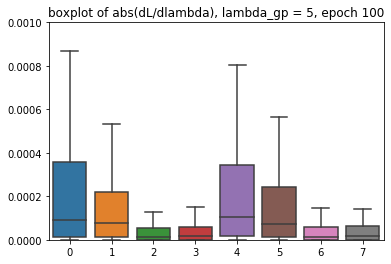

In [9]:
sns.boxplot(data = np.abs(np.array(gradient_lambda5_e100.detach())), showfliers = False)
plt.title('boxplot of abs(dL/dlambda), lambda_gp = 5, epoch 100')
plt.ylim(0,0.0010)
plt.show()

In [10]:
gradient_lambda5_e10 = cal_gradient_lambda(resume = 'resnet18_aam_new_gp5_0_n1.pth9', norm = 1, lambda_gp = 5)

==> Building model..
==> Resuming from checkpoint..

Epoch: 10


gp: 0.00289 ,  loss: 5.921,  final_loss: 5.936:           | 0/98 [00:03<?, ?it/s]


Text(0.5, 1.0, 'boxplot of abs(dL/dlambda), lambda_gp = 5, epoch 10')

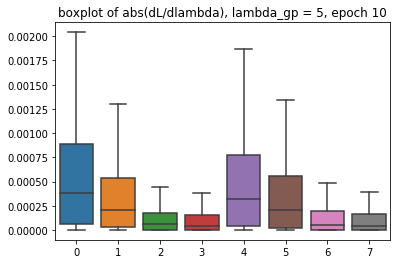

In [11]:
sns.boxplot(data = np.abs(np.array(gradient_lambda5_e10.detach())), showfliers = False)
plt.title('boxplot of abs(dL/dlambda), lambda_gp = 5, epoch 10')

In [12]:
gradient_lambda5_e10.size()

torch.Size([512, 8])

In [13]:
gradient_lambda5_e10.var(dim=0).sum()

tensor(5.7732e-06, grad_fn=<SumBackward0>)

In [14]:
gradient_lambda30_e100 = cal_gradient_lambda(resume = 'resnet18_realaam_gp_30_0_n1.pth99', norm = 1, lambda_gp = 30)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00127 ,  loss: 5.542,  final_loss: 5.580:           | 0/98 [00:03<?, ?it/s]


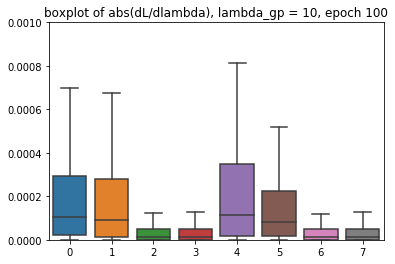

In [15]:
sns.boxplot(data = np.abs(np.array(gradient_lambda30_e100.detach())), showfliers = False)
plt.title('boxplot of abs(dL/dlambda), lambda_gp = 10, epoch 100')
plt.ylim(0,0.0010)
plt.show()

In [16]:
gradient_lambda0_e100 = cal_gradient_lambda(resume = 'resnet18_aam_new_baseline_rerun.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00151 ,  loss: 5.469,  final_loss: 5.469:           | 0/98 [00:03<?, ?it/s]


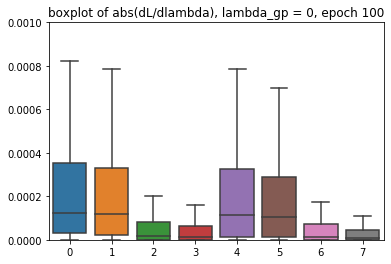

In [17]:
sns.boxplot(data = np.abs(np.array(gradient_lambda0_e100.detach())), showfliers = False)
plt.title('boxplot of abs(dL/dlambda), lambda_gp = 0, epoch 100')
plt.ylim(0,0.0010)
plt.show()

In [18]:
gradient_lambda1000_e100 = cal_gradient_lambda(resume = 'resnet18_aam_new_gp1000_0_n1.pth99', norm = 1, lambda_gp = 1000)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00205 ,  loss: 5.463,  final_loss: 7.516:           | 0/98 [00:03<?, ?it/s]


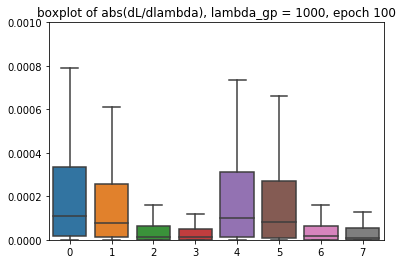

In [19]:
sns.boxplot(data = np.abs(np.array(gradient_lambda1000_e100.detach())), showfliers = False)
plt.title('boxplot of abs(dL/dlambda), lambda_gp = 1000, epoch 100')
plt.ylim(0,0.0010)
plt.show()

In [20]:
gradient_lambda10_e100 = cal_gradient_lambda(resume = 'resnet18_realaam_gp_10_0_n1.pth99', norm = 1, lambda_gp = 10)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00121 ,  loss: 5.469,  final_loss: 5.481:           | 0/98 [00:03<?, ?it/s]


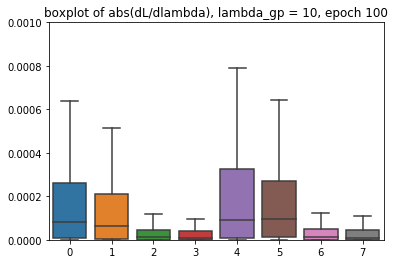

In [21]:
sns.boxplot(data = np.abs(np.array(gradient_lambda10_e100.detach())), showfliers = False)
plt.title('boxplot of abs(dL/dlambda), lambda_gp = 10, epoch 100')
plt.ylim(0,0.0010)
plt.show()

In [22]:
gradient_lambda10_e100.norm(p=1, dim=0)

tensor([0.1267, 0.0965, 0.0225, 0.0225, 0.1647, 0.1352, 0.0265, 0.0233],
       grad_fn=<NormBackward1>)

In [23]:
gradient_lambda5_e100.norm(p=1, dim=0)

tensor([0.2243, 0.1654, 0.0270, 0.0297, 0.1419, 0.0988, 0.0270, 0.0338],
       grad_fn=<NormBackward1>)

In [24]:
gradient_lambda0_e100.norm(p=1, dim=0)

tensor([0.1665, 0.1537, 0.0372, 0.0303, 0.1852, 0.1461, 0.0301, 0.0225],
       grad_fn=<NormBackward1>)

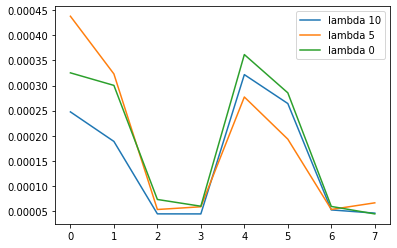

In [25]:
plt.plot(gradient_lambda10_e100.detach().norm(p=1, dim=0)/512, label = 'lambda 10')
plt.plot(gradient_lambda5_e100.detach().norm(p=1, dim=0)/512, label = 'lambda 5')
plt.plot(gradient_lambda0_e100.detach().norm(p=1, dim=0)/512, label = 'lambda 0')
plt.legend()
plt.show()

# has too many outlier!?

Text(0.5, 1.0, 'boxplot of abs(dL/dlambda), lambda_gp = 10, epoch 100')

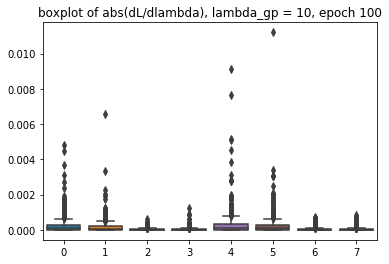

In [26]:
sns.boxplot(data = np.abs(np.array(gradient_lambda10_e100.detach())), showfliers = True)
plt.title('boxplot of abs(dL/dlambda), lambda_gp = 10, epoch 100')

Text(0.5, 1.0, 'boxplot of abs(dL/dlambda), lambda_gp = 5, epoch 100')

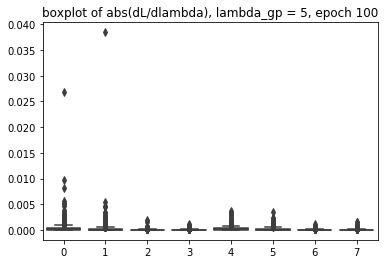

In [27]:
sns.boxplot(data = np.abs(np.array(gradient_lambda5_e100.detach())), showfliers = True)
plt.title('boxplot of abs(dL/dlambda), lambda_gp = 5, epoch 100')

Text(0.5, 1.0, 'boxplot of abs(dL/dlambda), lambda_gp = 0, epoch 100')

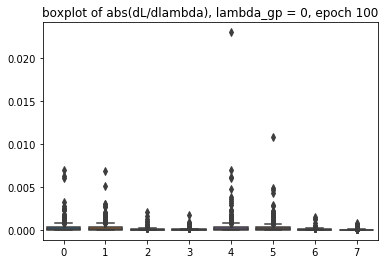

In [28]:
sns.boxplot(data = np.abs(np.array(gradient_lambda0_e100.detach())), showfliers = True)
plt.title('boxplot of abs(dL/dlambda), lambda_gp = 0, epoch 100')

try with log 

Text(0.5, 1.0, 'boxplot of log abs(dL/dlambda), lambda_gp = 10, epoch 100')

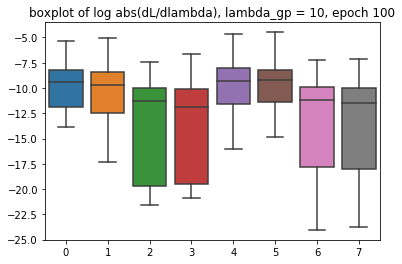

In [29]:
sns.boxplot(data = torch.log(torch.abs(gradient_lambda10_e100)).detach())
plt.title('boxplot of log abs(dL/dlambda), lambda_gp = 10, epoch 100')

Text(0.5, 1.0, 'boxplot of log abs(dL/dlambda), lambda_gp = 0, epoch 100')

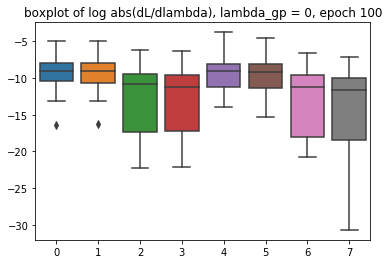

In [30]:
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_e100)).detach())
plt.title('boxplot of log abs(dL/dlambda), lambda_gp = 0, epoch 100')

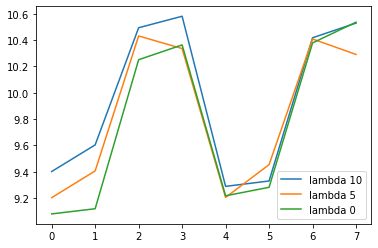

In [31]:
plt.plot(torch.log(torch.abs(gradient_lambda10_e100)+0.00001).detach().norm(p=1, dim=0)/512, label = 'lambda 10')
plt.plot(torch.log(torch.abs(gradient_lambda5_e100)+0.00001).detach().norm(p=1, dim=0)/512, label = 'lambda 5')
plt.plot(torch.log(torch.abs(gradient_lambda0_e100)+0.00001).detach().norm(p=1, dim=0)/512, label = 'lambda 0')
plt.legend()
plt.show()

In [32]:
torch.log(torch.abs(gradient_lambda10_e100)+0.00001).mean()

tensor(-9.9561, grad_fn=<MeanBackward0>)

In [33]:
gradient_lambda0_1_e100_log = cal_gradient_lambda(resume = 'resnet18_aam_log_gp0_1_n1.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00124 ,  loss: 5.520,  final_loss: 5.520:           | 0/98 [00:03<?, ?it/s]


In [34]:
gradient_lambda0_001_e100_log_small = cal_gradient_lambda(resume = 'resnet18_aam_log_gp0_001_n1_small.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00143 ,  loss: 5.519,  final_loss: 5.519:           | 0/98 [00:03<?, ?it/s]


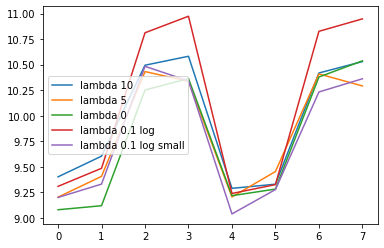

In [35]:
plt.plot(torch.log(torch.abs(gradient_lambda10_e100)+0.00001).detach().norm(p=1, dim=0)/512, label = 'lambda 10')
plt.plot(torch.log(torch.abs(gradient_lambda5_e100)+0.00001).detach().norm(p=1, dim=0)/512, label = 'lambda 5')
plt.plot(torch.log(torch.abs(gradient_lambda0_e100)+0.00001).detach().norm(p=1, dim=0)/512, label = 'lambda 0')
plt.plot(torch.log(torch.abs(gradient_lambda0_1_e100_log)+0.00001).detach().norm(p=1, dim=0)/512, label = 'lambda 0.1 log')
plt.plot(torch.log(torch.abs(gradient_lambda0_001_e100_log_small)+0.00001).detach().norm(p=1, dim=0)/512, label = 'lambda 0.1 log small')
plt.legend()
plt.show()

Text(0.5, 1.0, 'boxplot of log abs(dL/dlambda), lambda_gp = 0.001 small log , epoch 100')

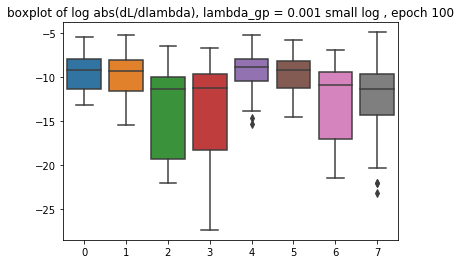

In [36]:
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_001_e100_log_small)).detach())
plt.title('boxplot of log abs(dL/dlambda), lambda_gp = 0.001 small log , epoch 100')

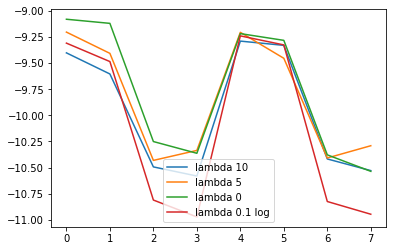

In [37]:
plt.plot(torch.log(torch.abs(gradient_lambda10_e100)+0.00001).mean(dim = 0).detach(), label = 'lambda 10')
plt.plot(torch.log(torch.abs(gradient_lambda5_e100)+0.00001).mean(dim = 0).detach(), label = 'lambda 5')
plt.plot(torch.log(torch.abs(gradient_lambda0_e100)+0.00001).mean(dim = 0).detach(), label = 'lambda 0')
plt.plot(torch.log(torch.abs(gradient_lambda0_1_e100_log)+0.00001).mean(dim = 0).detach(), label = 'lambda 0.1 log')
plt.legend()
plt.show()

In [38]:
torch.log(torch.abs(gradient_lambda0_1_e100_log)+0.00001).mean(dim = 0)

tensor([ -9.3087,  -9.4853, -10.8115, -10.9732,  -9.2393,  -9.3258, -10.8257,
        -10.9474], grad_fn=<MeanBackward1>)

In [39]:
torch.log(torch.abs(gradient_lambda0_1_e100_log)+0.00000000001).mean(dim = 0)

tensor([-12.5969, -12.7919, -15.1281, -15.5044, -12.2990, -12.3674, -15.1416,
        -15.5118], grad_fn=<MeanBackward1>)

Text(0.5, 1.0, 'boxplot of log abs(dL/dlambda), lambda_gp = 0 and log, epoch 100')

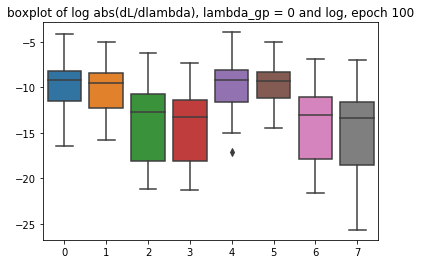

In [40]:
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_1_e100_log)).detach())
plt.title('boxplot of log abs(dL/dlambda), lambda_gp = 0 and log, epoch 100')

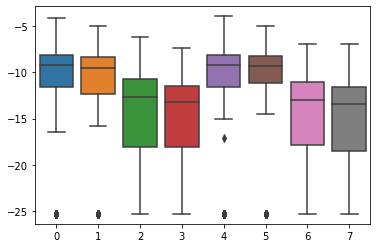

In [41]:
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_1_e100_log)+0.00000000001).detach())

In [42]:
gradient_lambda0_e1000 = cal_gradient_lambda(resume = 'resnet18_aam_new_baseline_rerun.pth999', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 1000


gp: 0.00135 ,  loss: 5.301,  final_loss: 5.301:           | 0/98 [00:02<?, ?it/s]


In [43]:
gradient_lambda0_e500 = cal_gradient_lambda(resume = 'resnet18_aam_new_baseline_rerun.pth499', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 500


gp: 0.00157 ,  loss: 5.319,  final_loss: 5.319:           | 0/98 [00:03<?, ?it/s]


Text(0.5, 1.0, 'boxplot of log abs(dL/dlambda), lambda_gp = 0 and log, epoch 1000')

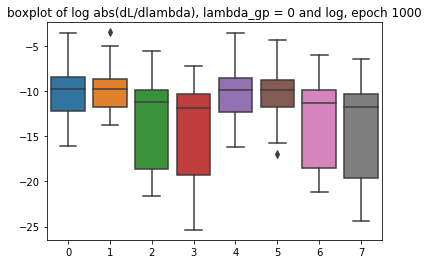

In [44]:
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_e1000)).detach())
plt.title('boxplot of log abs(dL/dlambda), lambda_gp = 0 and log, epoch 1000')

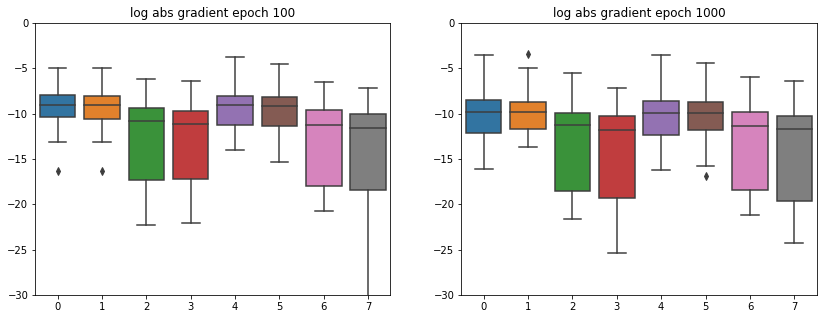

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-30,0])
ax2.set_ylim([-30,0])
ax1.title.set_text('log abs gradient epoch 100')
ax2.title.set_text('log abs gradient epoch 1000')
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_e100)).detach(), ax = ax1)
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_e1000)).detach(), ax = ax2)
plt.show()

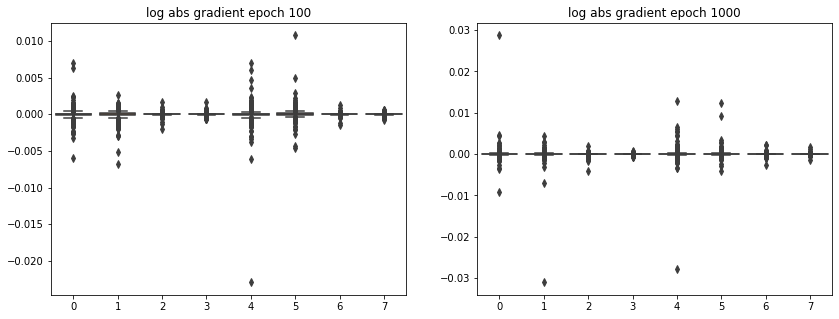

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
# ax1.set_ylim([-30,0])
# ax2.set_ylim([-30,0])
ax1.title.set_text('log abs gradient epoch 100')
ax2.title.set_text('log abs gradient epoch 1000')
sns.boxplot(data = ((gradient_lambda0_e100)).detach(), ax = ax1)
sns.boxplot(data = ((gradient_lambda0_e1000)).detach(), ax = ax2)
plt.show()

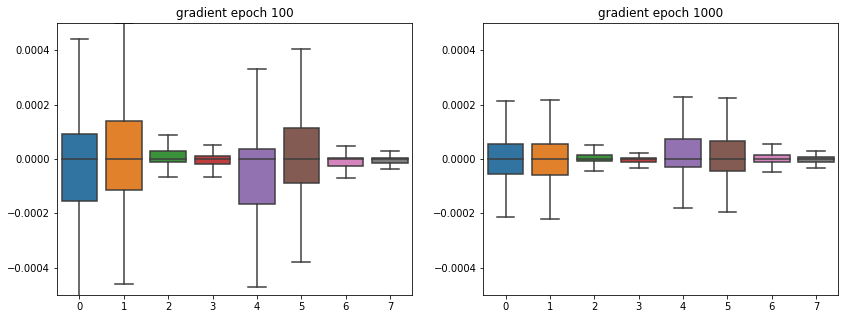

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-0.0005,0.0005])
ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100')
ax2.title.set_text('gradient epoch 1000')
sns.boxplot(data = ((gradient_lambda0_e100)).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = ((gradient_lambda0_e1000)).detach(), ax = ax2, showfliers = False)
plt.show()

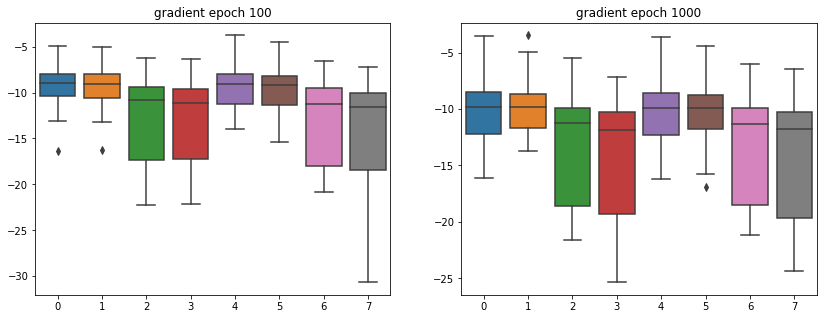

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
# ax1.set_ylim([-0.0005,0.0005])
# ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100')
ax2.title.set_text('gradient epoch 1000')
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_e100)).detach(), ax = ax1)
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_e1000)).detach(), ax = ax2)
plt.show()

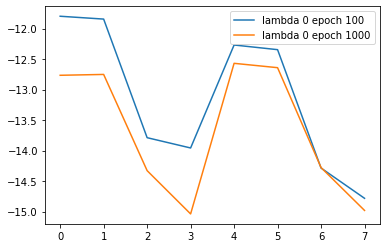

In [49]:
plt.plot(torch.log(torch.abs(gradient_lambda0_e100)+0.00000000001).mean(dim = 0).detach(), label = 'lambda 0 epoch 100')
# plt.plot(torch.log(torch.abs(gradient_lambda0_e500)+0.00001).mean(dim = 0).detach(), label = 'lambda 0 epoch 500')
plt.plot(torch.log(torch.abs(gradient_lambda0_e1000)+0.00000000001).mean(dim = 0).detach(), label = 'lambda 0 epoch 1000')
plt.legend()
plt.show()

# 50 epochs

In [50]:
gradient_lambda0_001_e50_log_small = cal_gradient_lambda(resume = 'resnet18_aam_log_gp0_001_n1_small.pth49', norm = 1, lambda_gp = 0)
gradient_lambda10_e50 = cal_gradient_lambda(resume = 'resnet18_realaam_gp_10_0_n1.pth49', norm = 1, lambda_gp = 10)
gradient_lambda5_e50 = cal_gradient_lambda(resume = 'resnet18_aam_new_gp5_0_n1.pth49', norm = 1, lambda_gp = 5)
gradient_lambda0_e50 = cal_gradient_lambda(resume = 'resnet18_aam_new_baseline_rerun.pth49', norm = 1, lambda_gp = 0)


==> Building model..
==> Resuming from checkpoint..

Epoch: 50


gp: 0.00174 ,  loss: 5.579,  final_loss: 5.579:           | 0/98 [00:03<?, ?it/s]


==> Building model..
==> Resuming from checkpoint..

Epoch: 50


gp: 0.00155 ,  loss: 5.585,  final_loss: 5.600:           | 0/98 [00:03<?, ?it/s]


==> Building model..
==> Resuming from checkpoint..

Epoch: 50


gp: 0.00154 ,  loss: 5.534,  final_loss: 5.542:           | 0/98 [00:03<?, ?it/s]


==> Building model..
==> Resuming from checkpoint..

Epoch: 50


gp: 0.00157 ,  loss: 5.520,  final_loss: 5.520:           | 0/98 [00:03<?, ?it/s]


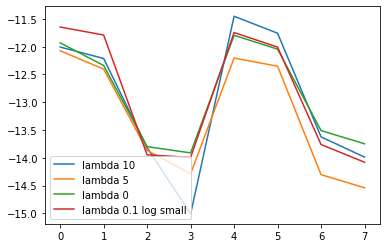

In [51]:
plt.plot(torch.log(torch.abs(gradient_lambda10_e50)+0.00000000001).mean(dim = 0).detach(), label = 'lambda 10')
plt.plot(torch.log(torch.abs(gradient_lambda5_e50)+0.00000000001).mean(dim = 0).detach(), label = 'lambda 5')
plt.plot(torch.log(torch.abs(gradient_lambda0_e50)+0.00000000001).mean(dim = 0).detach(), label = 'lambda 0')
plt.plot(torch.log(torch.abs(gradient_lambda0_001_e50_log_small)+0.00000000001).mean(dim = 0).detach(), label = 'lambda 0.1 log small')
plt.legend()
plt.show()

# see what happen with all train dataset !?

In [8]:
def cal_gradient_lambda_full(resume, norm, lambda_gp):
    # config
    ### config ####
    gradient_lambda_list = []

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    base_lr = 0.25
    arch = 'resnet18'
    momentum = 0.9
    cosine_anneal = True
    num_epochs = 1
    test_freq = 1
    lr = base_lr * (batch_size / 256)
    
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    last_epoch = num_epochs #last epoch or from last epoch from checkpoint 
    clf = None
    current_checkpoint = {}
    acc = 0
    # Model
    print('==> Building model..')
    ##############################################################
    # Encoder
    ##############################################################
    if arch == 'resnet18':
        net = ResNet18(stem=stem)
    elif arch == 'resnet34':
        net = ResNet34(stem=stem)
    elif arch == 'resnet50':
        net = ResNet50(stem=stem)
    else:
        raise ValueError("Bad architecture specification")
    net = net.to(device)

    ##############################################################
    # Critic
    ##############################################################
    critic = LinearCritic(net.representation_dim, temperature=temperature).to(device)

    ###### Differentiable augmentation ######
    brightness_bound = [0.2, 1.8]
    contrast_bound = [0.2, 1.8]
    saturation_bound = [0.2, 1.8]
    hue_bound = [-0.2, 0.2]

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    base_optimizer = optim.SGD(list(net.parameters()) + list(critic.parameters()), lr=lr, weight_decay=1e-6,
                               momentum=momentum)
    if cosine_anneal == True:
        scheduler = CosineAnnealingWithLinearRampLR(base_optimizer, num_epochs)
    encoder_optimizer = LARS(base_optimizer, trust_coef=1e-3)

    #Resume
    if resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        resume_from = os.path.join('./checkpoint', resume)
        checkpoint = torch.load(resume_from)
        net.load_state_dict(checkpoint['net'])
        critic.load_state_dict(checkpoint['critic'])
    #     best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch'] + 1
        encoder_optimizer.load_state_dict(checkpoint['encoder_optim'])
        base_optimizer.load_state_dict(checkpoint['base_optim'])
        scheduler.step(start_epoch)
        if 'num_epochs' in checkpoint:
            last_epoch = checkpoint['num_epochs']
        else:
            last_epoch = 1000 #default value for num epochs = 1000
        current_checkpoint = checkpoint
        ##### Train #####
        print('\nEpoch: %d' % start_epoch)
        net.train()
        critic.train()
        train_loss = 0
        sum_gradient = 0
        train_loss_nogp = 0
        t = tqdm(enumerate(trainloader), desc='Loss: **** ', total=len(trainloader), bar_format='{desc}{bar}{r_bar}')
        for batch_idx, (inputs, _, _) in t:
            x1, x2 = inputs
            x1, x2 = x1.to(device), x2.to(device)

            #colour augmentation
            B = x1.size()[0]
            brightness_list1, saturation_list1, contrast_list1, hue_list1 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            brightness_list2, saturation_list2, contrast_list2, hue_list2 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            lambda_ = torch.stack([brightness_list1, saturation_list1, contrast_list1, hue_list1,
                                   brightness_list2, saturation_list2, contrast_list2, hue_list2], dim=1)
            aug_manual1 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,0],
                                                                       contrast = lambda_[:,1],
                                                                       saturation = lambda_[:,2],
                                                                       hue = lambda_[:,3])
            aug_manual2 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,4],
                                                                       contrast = lambda_[:,5],
                                                                       saturation = lambda_[:,6],
                                                                       hue = lambda_[:,7])

            x1, x2 = aug_manual1(x1), aug_manual2(x2)
            x1, x2 = ManualNormalise(x1, dataset), ManualNormalise(x2, dataset)

            encoder_optimizer.zero_grad()
            representation1, representation2 = net(x1), net(x2)
            raw_scores, pseudotargets = critic(representation1, representation2)
            loss = criterion(raw_scores, pseudotargets)

            # Gradient penalty
            gradient_lambda =  autograd.grad(outputs = loss,
                                 inputs = lambda_,
                                 create_graph = False,
                                 retain_graph = False,
                                 only_inputs = True)[0]

            # take norm before mean
            gradient_penalty = gradient_lambda.norm(p=norm, dim=1).mean(0)


            loss_gp = loss + lambda_gp * gradient_penalty.to(device)
#             loss_gp.backward()
#             encoder_optimizer.step()

            train_loss += loss_gp.item()
            sum_gradient += gradient_penalty
            train_loss_nogp += loss

            t.set_description('gp: {:0.5f} ,  loss: {:0.3f},  final_loss: {:0.3f}'.format((sum_gradient / (batch_idx + 1)), (train_loss_nogp / (batch_idx + 1)), (train_loss / (batch_idx + 1))))
            
            gradient_lambda_list.append(gradient_lambda)
    return torch.cat(gradient_lambda_list, dim = 0)

## 100 epochs vs 1000 epochs normal simclr

In [9]:
gradient_lambda0_e1000_full = cal_gradient_lambda_full(resume = 'resnet18_aam_new_baseline_rerun.pth999', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 1000


gp: 0.00142 ,  loss: 5.280,  final_loss: 5.280: ██████████| 98/98 [00:58<00:00,  1.68it/s]


In [10]:
gradient_lambda0_e100_full = cal_gradient_lambda_full(resume = 'resnet18_aam_new_baseline_rerun.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00147 ,  loss: 5.458,  final_loss: 5.458: ██████████| 98/98 [00:54<00:00,  1.81it/s]


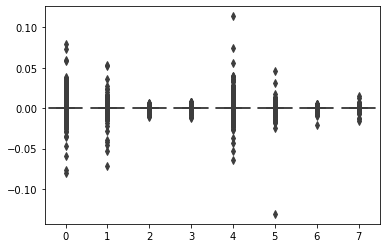

In [55]:
sns.boxplot(data = ((gradient_lambda0_e1000_full)).detach(), showfliers = True)

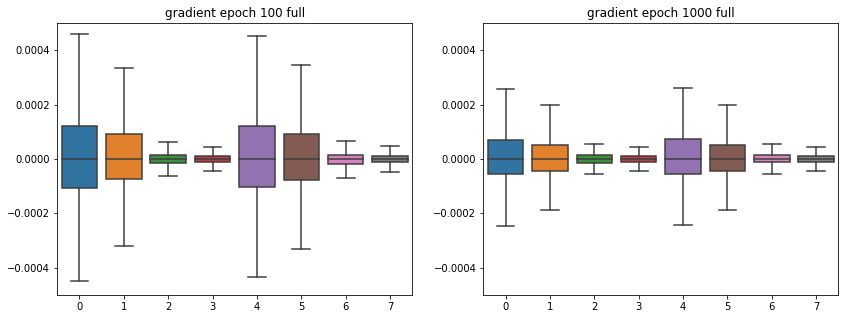

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-0.0005,0.0005])
ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 1000 full')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = ((gradient_lambda0_e1000_full)).detach(), ax = ax2, showfliers = False)
plt.show()

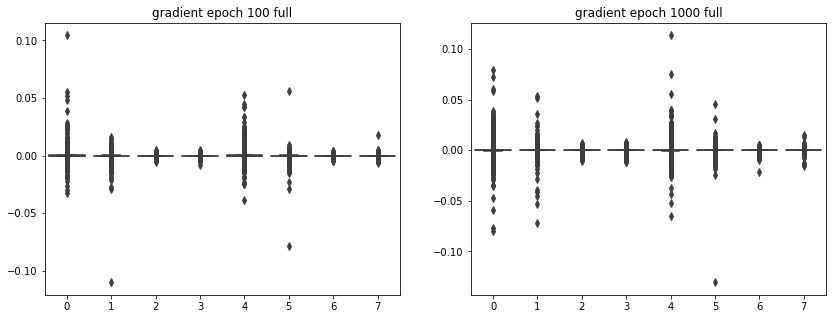

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
# ax1.set_ylim([-0.0005,0.0005])
# ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 1000 full')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1)
sns.boxplot(data = ((gradient_lambda0_e1000_full)).detach(), ax = ax2)
plt.show()

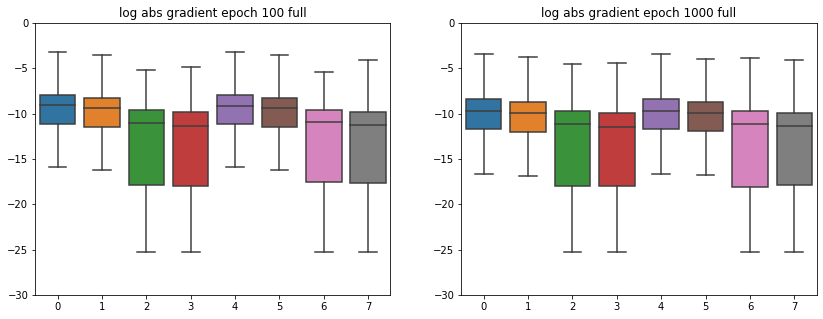

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-30,0])
ax2.set_ylim([-30,0])
ax1.title.set_text('log abs gradient epoch 100 full')
ax2.title.set_text('log abs gradient epoch 1000 full')
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_e100_full)+0.00000000001).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_e1000_full)+0.00000000001).detach(), ax = ax2, showfliers = False)
plt.show()

# 100 epochs original simclr vs with gradient penalty lambda = 5

In [59]:
gradient_lambda5_e100_full = cal_gradient_lambda_full(resume = 'resnet18_aam_new_gp5_0_n1.pth99', norm = 1, lambda_gp = 5)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00135 ,  loss: 5.462,  final_loss: 5.469: ██████████| 98/98 [00:58<00:00,  1.68it/s]


In [60]:
gradient_lambda10_e100_full = cal_gradient_lambda_full(resume = 'resnet18_realaam_gp_10_0_n1.pth99', norm = 1, lambda_gp = 10)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00133 ,  loss: 5.468,  final_loss: 5.482: ██████████| 98/98 [00:58<00:00,  1.67it/s]


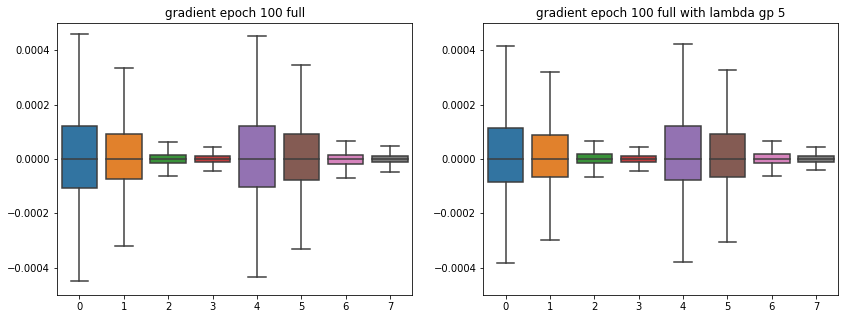

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-0.0005,0.0005])
ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 100 full with lambda gp 5')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = ((gradient_lambda5_e100_full)).detach(), ax = ax2, showfliers = False)
plt.show()

varinace of 100 epochs vs 1000 epoch

In [62]:
gradient_lambda0_e100_full.var(dim = 0)

tensor([1.3520e-06, 6.1596e-07, 2.8725e-08, 3.1165e-08, 1.1495e-06, 5.1528e-07,
        3.2879e-08, 3.8187e-08])

In [63]:
gradient_lambda0_e1000_full.var(dim = 0)

tensor([2.5401e-06, 8.2909e-07, 6.5902e-08, 7.0787e-08, 2.1691e-06, 7.4610e-07,
        6.6494e-08, 7.9001e-08])

In [64]:
gradient_lambda0_e100_full.norm(p = 2, dim = 0)

tensor([0.2601, 0.1755, 0.0379, 0.0395, 0.2399, 0.1605, 0.0406, 0.0437])

In [65]:
gradient_lambda0_e1000_full.norm(p = 2, dim = 0)

tensor([0.3565, 0.2036, 0.0574, 0.0595, 0.3295, 0.1931, 0.0577, 0.0628])

In [66]:
gradient_lambda0_e100_full.norm(p = 1, dim = 0)

tensor([18.2177, 11.9228,  3.3124,  2.9970, 17.8847, 12.0303,  3.5127,  3.1400])

In [67]:
gradient_lambda0_e1000_full.norm(p = 1, dim = 0)

tensor([18.1795, 10.1346,  3.7118,  3.4127, 17.3027,  9.7652,  3.6772,  3.5167])

In [68]:
gradient_lambda0_e100_full.norm(p = 0.5, dim = 0).mean()/512

tensor(435.4576)

In [69]:
gradient_lambda0_e1000_full.norm(p = 0.5, dim = 0).mean()/512

tensor(341.8886)

In [70]:
(gradient_lambda0_e100_full+1e-16).norm(p = 0.5, dim = 0).mean()/512

tensor(435.4576)

In [71]:
(gradient_lambda0_e1000_full+1e-16).norm(p = 0.5, dim = 0).mean()/512

tensor(341.8886)

In [72]:
gradient_lambda1_n0_5_e100_full = cal_gradient_lambda_full(resume = 'resnet18_aam_gp_1_0_n0_5.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00141 ,  loss: 5.538,  final_loss: 5.538: ██████████| 98/98 [00:57<00:00,  1.71it/s]


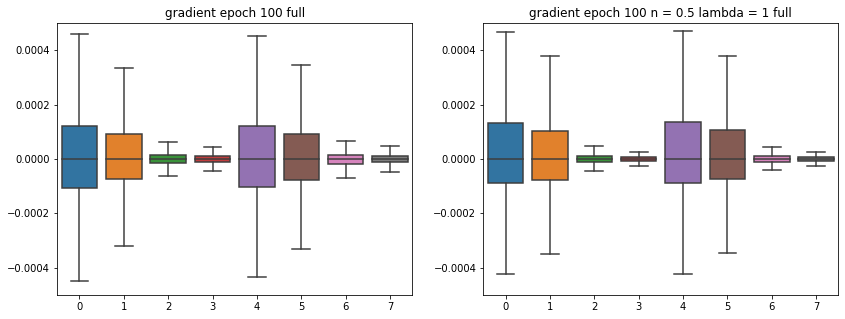

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-0.0005,0.0005])
ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 100 n = 0.5 lambda = 1 full')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = ((gradient_lambda1_n0_5_e100_full)).detach(), ax = ax2, showfliers = False)
plt.show()

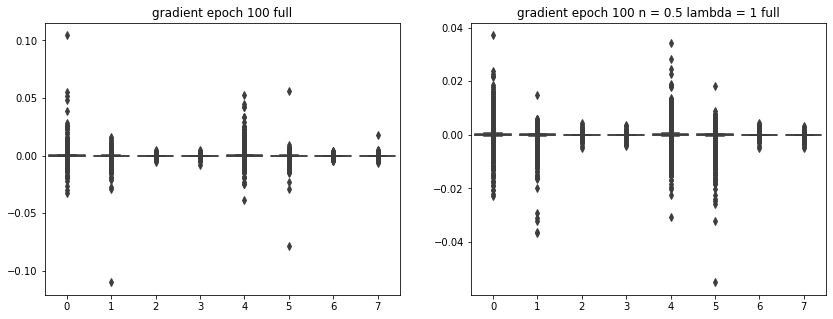

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
# ax1.set_ylim([-0.0005,0.0005])
# ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 100 n = 0.5 lambda = 1 full')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1, showfliers = True)
sns.boxplot(data = ((gradient_lambda1_n0_5_e100_full)).detach(), ax = ax2, showfliers = True)
plt.show()

In [74]:
(gradient_lambda1_n0_5_e100_full+1e-16).norm(p = 0.5, dim = 0).mean()/512

tensor(422.2264)

In [75]:
(gradient_lambda0_e100_full+1e-16).norm(p = 0.5, dim = 0).mean()/512

tensor(435.4576)

In [77]:
gradient_lambda0_e100_full[:,0].norm(p=0.5)

tensor(446916.3125)

In [78]:
gradient_lambda1_n0_5_e100_full[:,0].norm(p=0.5)

tensor(436711.1562)

In [80]:
gradient_lambda0_e100_full.var(dim = 0)

tensor([1.3520e-06, 6.1596e-07, 2.8725e-08, 3.1165e-08, 1.1495e-06, 5.1528e-07,
        3.2879e-08, 3.8187e-08])

In [81]:
gradient_lambda0_e1000_full.var(dim = 0)

tensor([2.5401e-06, 8.2909e-07, 6.5902e-08, 7.0787e-08, 2.1691e-06, 7.4610e-07,
        6.6494e-08, 7.9001e-08])

In [83]:
gradient_lambda0_e100_full.norm(p=2, dim = 0)

tensor([0.2601, 0.1755, 0.0379, 0.0395, 0.2399, 0.1605, 0.0406, 0.0437])

In [84]:
gradient_lambda0_e1000_full.norm(p=2, dim = 0)

tensor([0.3565, 0.2036, 0.0574, 0.0595, 0.3295, 0.1931, 0.0577, 0.0628])

In [92]:
gradient_lambda0_e1000_full.norm(p=2, dim = 0).var()

tensor(0.0158)

In [93]:
gradient_lambda0_e100_full.norm(p=2, dim = 0).var()

tensor(0.0091)

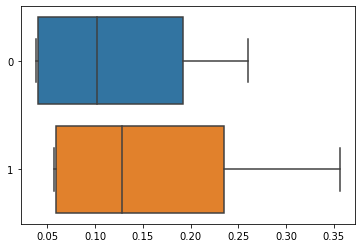

In [114]:
sns.boxplot(data = [gradient_lambda0_e100_full.norm(p=2, dim = 0), gradient_lambda0_e1000_full.norm(p=2, dim = 0)], orient = 'h')

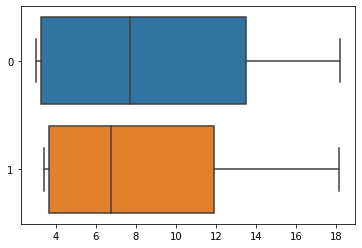

In [115]:
sns.boxplot(data = [gradient_lambda0_e100_full.norm(p=1, dim = 0), gradient_lambda0_e1000_full.norm(p=1, dim = 0)], orient = 'h')

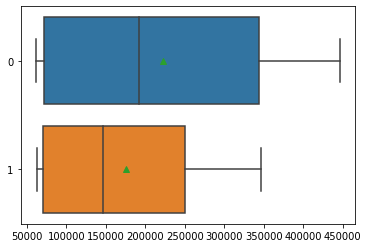

In [127]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=0.5, dim = 0), (gradient_lambda0_e1000_full+1e-16).norm(p=0.5, dim = 0)], orient = 'h', showmeans = True)

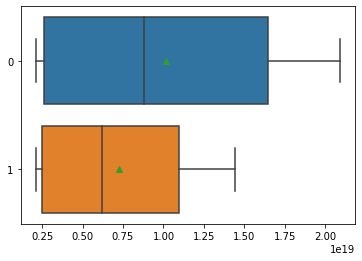

In [128]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=0.2, dim = 0), (gradient_lambda0_e1000_full+1e-16).norm(p=0.2, dim = 0)], orient = 'h', showmeans = True)

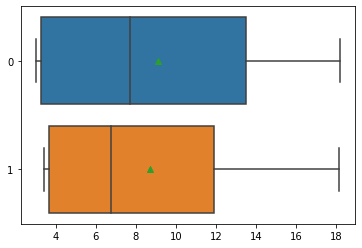

In [129]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 0), (gradient_lambda0_e1000_full+1e-16).norm(p=1, dim = 0)], orient = 'h', showmeans = True)

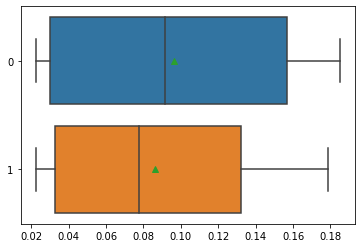

In [131]:
sns.boxplot(data = [(gradient_lambda0_e100+1e-16).norm(p=1, dim = 0).detach(), (gradient_lambda0_e1000+1e-16).norm(p=1, dim = 0).detach()], orient = 'h', showmeans = True)

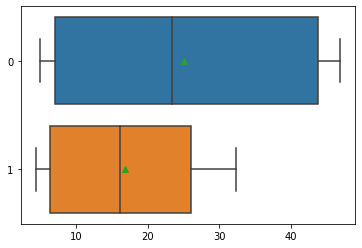

In [132]:
sns.boxplot(data = [(gradient_lambda0_e100+1e-16).norm(p=0.5, dim = 0).detach(), (gradient_lambda0_e1000+1e-16).norm(p=0.5, dim = 0).detach()], orient = 'h', showmeans = True)

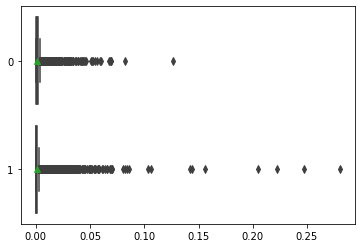

In [15]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()], orient = 'h', showmeans = True)

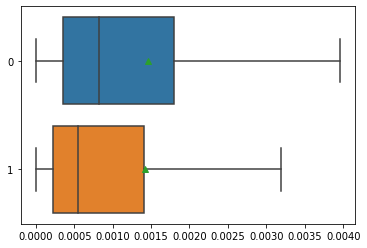

In [17]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)

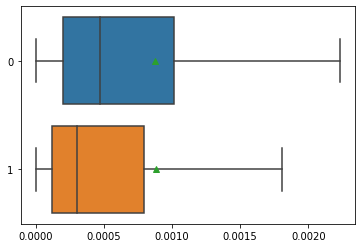

In [18]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=2, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=2, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)

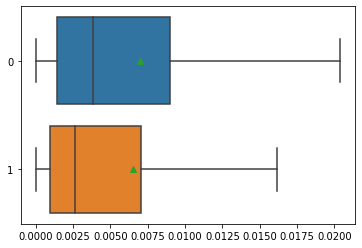

In [19]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=0.5, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=0.5, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)

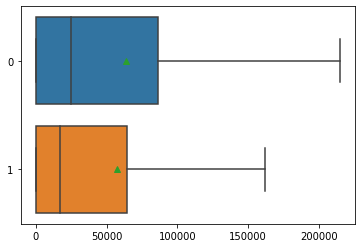

In [20]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=0.1, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=0.1, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)